In [41]:
import os
from glob import glob
import shutil
from pathlib import Path, PurePath

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2


import torchvision
from torchvision.transforms import transforms as T
from torchvision.utils import draw_bounding_boxes

from tqdm import tqdm

import albumentations as A

import time

%matplotlib inline
torch.manual_seed(42)


In [42]:
from sklearn.model_selection import train_test_split

In [43]:
print("Current working directory:", os.getcwd())

Current working directory: /Users/jhala/Documents/GitHub/Defect-detection-in-3D-printing/models


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
IMAGES = './train/images'
MASKS = './train/masks'
classes = './train/_classes.csv'

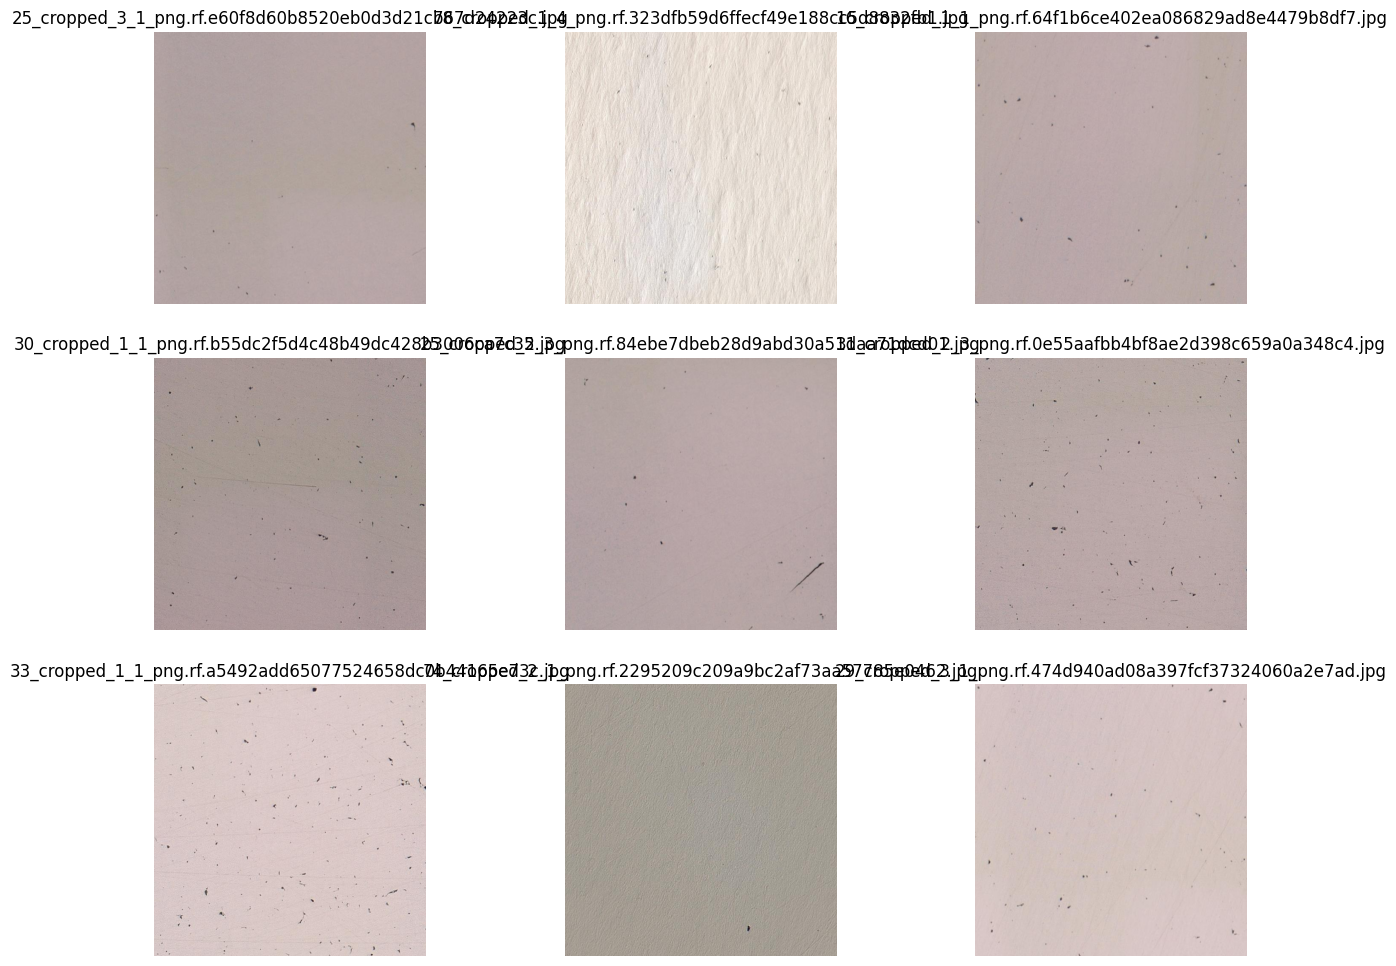

In [46]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))

image_paths = list(Path(IMAGES).iterdir())
shapes = []

for num, img_path in enumerate(image_paths[:9]):
    with Image.open(img_path) as img:
        shapes.append(img.size)
        plt.subplot(rows, cols, num + 1)
        plt.title(img_path.name)
        plt.axis('off')
        plt.imshow(img)

plt.show()


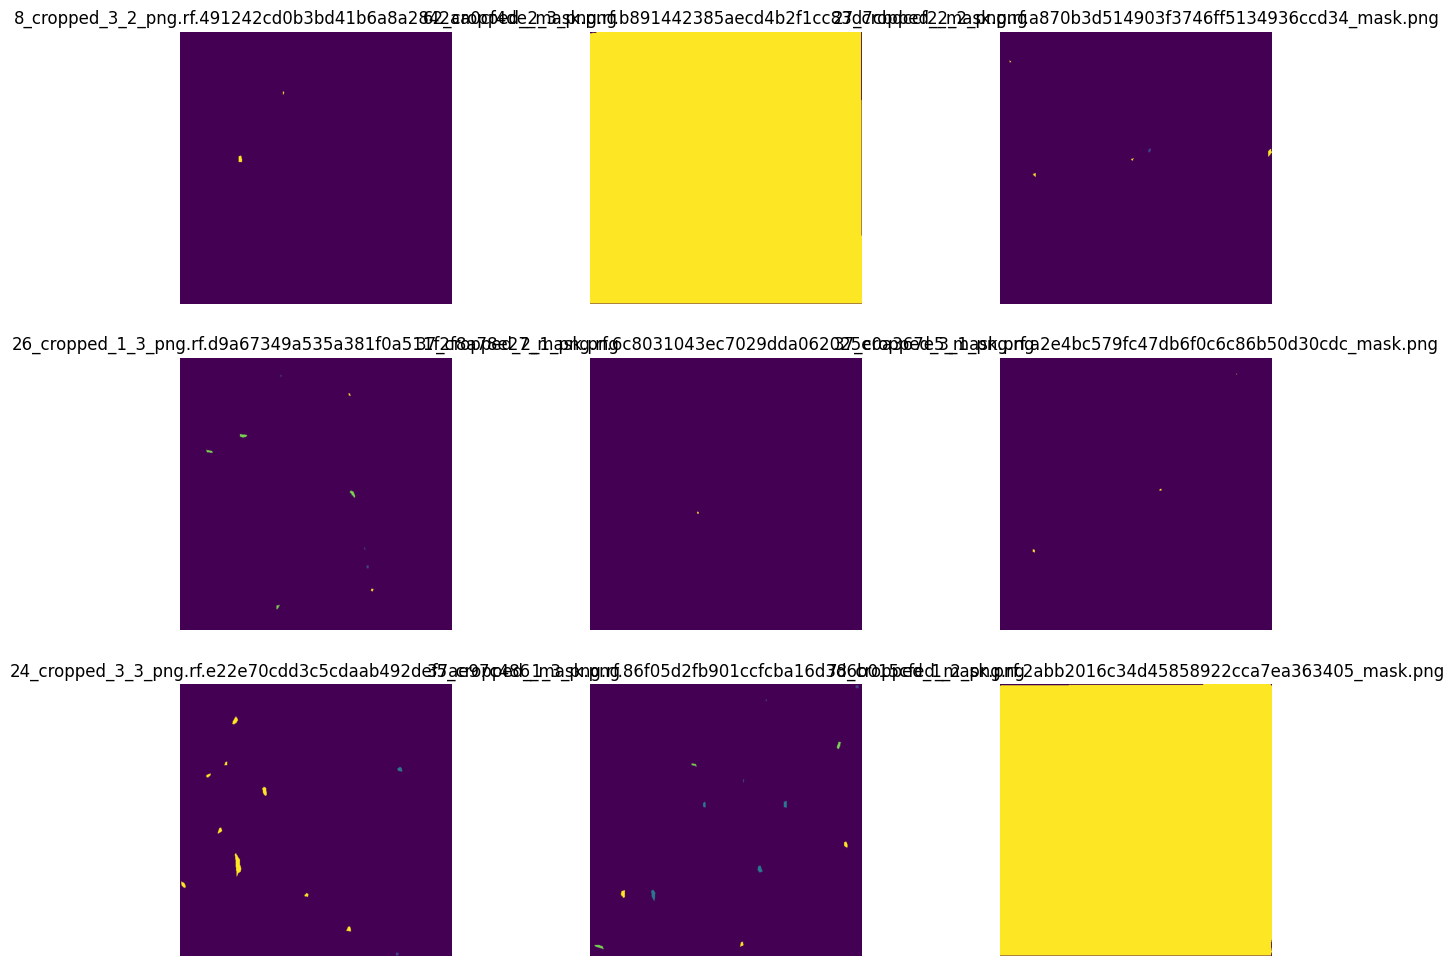

In [47]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))

masks_paths = list(Path(MASKS).iterdir())
shapes = []

for num, masks_paths in enumerate(masks_paths[:9]):
    with Image.open(masks_paths) as masks:
        shapes.append(masks.size)
        plt.subplot(rows, cols, num + 1)
        plt.title(masks_paths.name)
        plt.axis('off')
        plt.imshow(masks)

plt.show()

In [48]:
size = 256

In [49]:
class porosity_Dataset(Dataset):
    
    def __init__(self, image_path, mask_path, x, mean, std, transform=None, patch=False,
                 image_ext=".jpg", mask_ext=".png"):
        self.img_path = image_path
        self.mask_path = mask_path
        self.x = x  # list of base filenames (without extension)
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        self.image_ext = image_ext
        self.mask_ext = mask_ext
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image_filename = self.x[idx] + self.image_ext
        mask_filename = self.x[idx] + "_mask" + self.mask_ext

        img_path = os.path.join(self.img_path, image_filename)
        mask_path = os.path.join(self.mask_path, mask_filename)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        # else img is numpy array from cv2 already

        img = Image.fromarray(img)
        t = T.Compose([
            T.ToTensor(),
            T.Normalize(self.mean, self.std)
        ])
        img = t(img)

        mask = torch.tensor(mask, dtype=torch.long)  # convert to tensor explicitly

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        size = 256
        img_patches = img.unfold(1, size, size).unfold(2, size, size)
        img_patches = img_patches.contiguous().view(3, -1, size, size)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, size, size).unfold(1, size, size)
        mask_patches = mask_patches.contiguous().view(-1, size, size)

        return img_patches, mask_patches


In [50]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2),
                    A.GaussNoise(),
                    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2),])

In [51]:
x_all = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGES)])

In [52]:
x_train, x_val = train_test_split(x_all, test_size=0.05, random_state=42, shuffle=True)

In [53]:
train_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_train,
    mean=mean,
    std=std,
    transform=t_train,
    patch=True,
    image_ext=".jpg",   # images are .jpg
    mask_ext=".png"     # masks are .png
)

val_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_val,
    mean=mean,
    std=std,
    transform=t_val,
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)

In [54]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [55]:
class UNet(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
       
        
        """
        Encoder 
        
        Every block in encoder has 2 convolution layer followed by max pooling layer, except last block which do not have max pooling layer
        
        The input to the U-Net is 400*400*channels
        
        """
        
        self.enc_blk11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.enc_blk12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.enc_blk21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_blk22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.enc_blk31 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_blk32 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.enc_blk41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_blk42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.enc_blk51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc_blk52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        
        """
        Decoder
        Here Upsampling of layers are done
        """
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_blk11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_blk12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_blk21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_blk22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_blk31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_blk32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_blk41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_blk42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Output Layer
        self.out_layer = nn.Conv2d(64, n_class, kernel_size=1)
       
    
    
    def forward(self, x):
        
        # Encoder
        enc11 = self.relu(self.enc_blk11(x))
#         print("Encoder block 1 conv layer 1 ", enc11.shape)
        enc12 = self.relu(self.enc_blk12(enc11))
#         print("Encoder block 1 conv layer 2 ",enc12.shape)
        pool1 = self.pool(enc12)
#         print("Encoder block 1 pooling layer ",pool1.shape)
        
        enc21 = self.relu(self.enc_blk21(pool1))
#         print("Encoder block 2 conv layer 1 ",enc21.shape)
        enc22 = self.relu(self.enc_blk22(enc21))
#         print("Encoder block 2 conv layer 2 ",enc22.shape)
        pool2 = self.pool(enc22)
#         print("Encoder block 2 pooling layer ",pool2.shape)
        
        
        enc31 = self.relu(self.enc_blk31(pool2))
#         print("Encoder block 3 conv layer 1 ",enc31.shape)
        enc32 = self.relu(self.enc_blk32(enc31))
#         print("Encoder block 3 conv layer 2 ",enc32.shape)
        pool3 = self.pool(enc32)
#         print("Encoder block 3 pooling layer ",pool3.shape)
        
        enc41 = self.relu(self.enc_blk41(pool3))
#         print("Encoder block 4 conv layer 1 ", enc41.shape)
        enc42 = self.relu(self.enc_blk42(enc41))
#         print("Encoder block 4 conv layer 2 ", enc42.shape)
        pool4 = self.pool(enc42)
#         print("Encoder block 4 pooling layer ", pool4.shape)
        
        enc51 = self.relu(self.enc_blk51(pool4))
#         print("Encoder block 5 conv layer 1 ", enc51.shape)
        enc52 = self.relu(self.enc_blk52(enc51))
#         print("Encoder block 5 conv layer 2", enc52.shape)
        
        # Decoder
        
        up1 = self.upconv1(enc52)
#         print("Upsampling layer 1 ", up1.shape)
        up11 = torch.cat([up1, enc42], dim=1)
#         print("Upsampled value layer 1 ", up11.shape)
        dec11 = self.relu(self.dec_blk11(up11))
#         print("Decoder block 1 conv layer 1 ", dec11.shape)
        dec12 = self.relu(self.dec_blk12(dec11))
        
#         print("Decoder block 1 conv layer 2", dec12.shape)
        
        up2 = self.upconv2(dec12)
#         print("Upsampling layer 2 ", up2.shape)
        up22 = torch.cat([up2, enc32], dim=1)
#         print("Upsampled value layer 2 ", up22.shape)
        dec21 = self.relu(self.dec_blk21(up22))
#         print("Decoder block 2 conv layer 1 ", dec21.shape)
        dec22 = self.relu(self.dec_blk22(dec21))
#         print("Decoder block 2 conv layer 2 ", dec22.shape)
        
        up3 = self.upconv3(dec22)
#         print("Upsampling layer 3 ", up3.shape)
        up33 = torch.cat([up3, enc22], dim=1)
#         print("Upsampled value layer 3 ", up33.shape)
        dec31 = self.relu(self.dec_blk31(up33))
#         print("Decoder block 3 conv layer 1 ", dec31.shape)
        dec32 = self.relu(self.dec_blk32(dec31))
#         print("Decoder block 3 conv layer 2 ", dec32.shape)
        
        up4 = self.upconv4(dec32)
#         print("Upsampling layer 4 ", up4.shape)
        up44 = torch.cat([up4, enc12], dim=1)
#         print("Upsampled value layer 4 ", up44.shape)
        dec41 = self.relu(self.dec_blk41(up44))
#         print("Decoder block 4 conv layer 1 ", dec41.shape)
        dec42 = self.relu(self.dec_blk42(dec41))
#         print("Decoder block 4 conv layer 2 ", dec42.shape)
        
        out = self.out_layer(dec42)
#         print('Output ', out.shape)
       
        
        return out

In [56]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum() / float(correct.numel()))
    return accuracy


In [57]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for classes in range(0, n_classes):
            true_class = (pred_mask == classes)
            true_label = (mask == classes)
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [58]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()

    for epoch in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        # ------------------ Training ------------------
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data

            if patch:
                batch, n_tiles, c, h, w = image_tiles.size()      # (B, N, C, H, W)
                image_tiles = image_tiles.view(-1, c, h, w)       # (B*N, C, H, W)
                mask_tiles = mask_tiles.view(-1, h, w)            # (B*N, H, W)
            else:
                bs, c, h, w = image_tiles.size()

            if mask_tiles.dim() == 4 and mask_tiles.size(1) == 11:
                mask_tiles = torch.argmax(mask_tiles, dim=1)
            else:
                mask_tiles = mask_tiles.long()

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Forward pass
            output = model(image)

            # Loss
            loss = criterion(output, mask)

            # Metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            scheduler.step()
            running_loss += loss.item()

        # ------------------ Validation ------------------
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                image_tiles, mask_tiles = data

                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()
                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
                else:
                    bs, c, h, w = image_tiles.size()

                if mask_tiles.dim() == 4 and mask_tiles.size(1) == 11:
                    mask_tiles = torch.argmax(mask_tiles, dim=1)
                else:
                    mask_tiles = mask_tiles.long()

                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                output = model(image)

                val_iou_score += mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)

                loss = criterion(output, mask)
                test_loss += loss.item()

        # Logging
        train_losses.append(running_loss / len(train_loader))
        test_losses.append(test_loss / len(val_loader))

        if min_loss > (test_loss / len(val_loader)):
            print('Loss Decreasing.... {:.3f} >> {:.3f}'.format(min_loss, (test_loss / len(val_loader))))
            min_loss = (test_loss / len(val_loader))
            decrease += 1
            if decrease % 5 == 0:
                print('Saving Model.......')
                torch.save(model, 'model.pt')
        else:
            not_improve += 1
            print(f"Loss did not decrease for {not_improve} times")
            if not_improve == 7:
                print('Loss did not decrease for 7 times, Stopped Training..')
                break

        val_iou.append(val_iou_score / len(val_loader))
        train_iou.append(iou_score / len(train_loader))
        train_acc.append(accuracy / len(train_loader))
        val_acc.append(test_accuracy / len(val_loader))

        print("Epoch: {} / {} ".format(epoch + 1, epochs),
              "Train Loss: {:.3f} ".format(running_loss / len(train_loader)),
              "Val Loss: {:.3f} ".format(test_loss / len(val_loader)),
              "Train mIoU: {:.3f} ".format(iou_score / len(train_loader)),
              "Val mIoU: {:.3f} ".format(val_iou_score / len(val_loader)),
              "Train Accuracy: {:.3f} ".format(accuracy / len(train_loader)),
              "Val Accuracy: {:.3f} ".format(test_accuracy / len(val_loader)),
              "Time: {:.2f}m".format((time.time() - since) / 60))

    history = {
        'train_loss': train_losses,
        'val_loss': test_losses,
        'train_miou': train_iou,
        'val_miou': val_iou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': lrs
    }

    print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
    return history

In [59]:
model = UNet(11)
model.to(device)

UNet(
  (enc_blk11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (enc_blk21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk31): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk32): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_blk52): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), strid

In [60]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=True)

 33%|███▎      | 58/178 [08:39<17:54,  8.95s/it]


error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


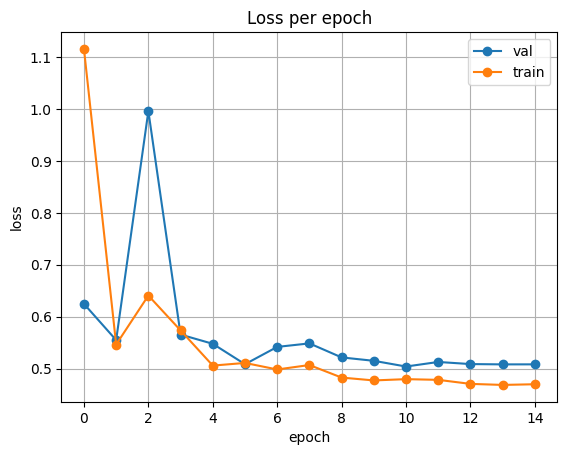

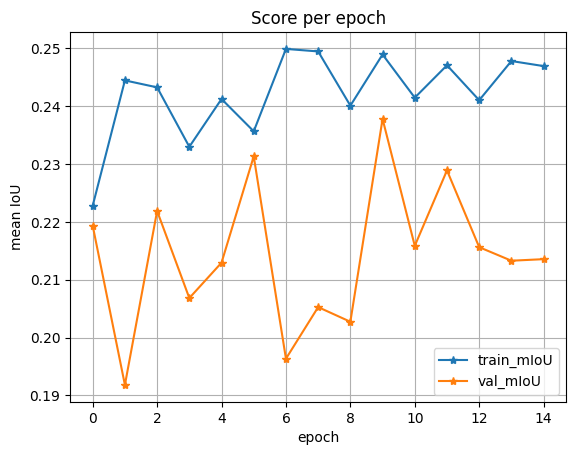

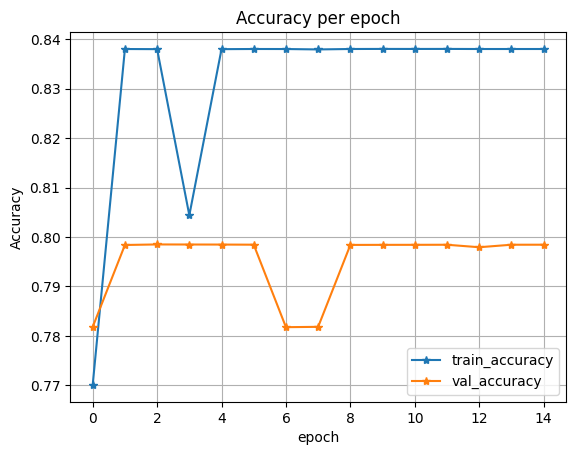

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


plot_loss(history)
plot_score(history)
plot_acc(history)